# [Computational Social Science] Project 4: Unsupervised Learning

Group Number: 8

Group Members:  
- Gailliot,Annette
- AMERKHANIAN,PETER
- Oyebanjo,Abiola


## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [130]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [156]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

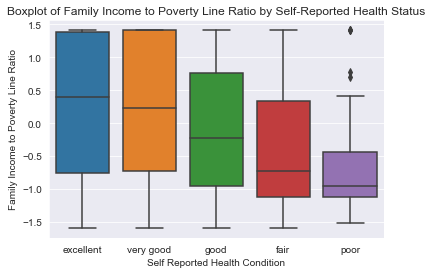

In [132]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

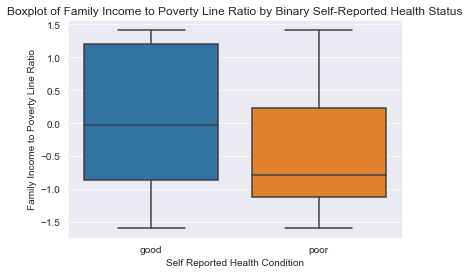

In [133]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

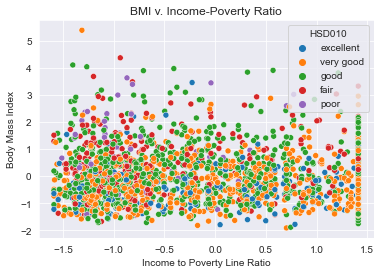

In [134]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [135]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [218]:
n_components = 30
# fitting
pca = PCA(n_components=n_components)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled)

# dataframing
pca_columns = [f"PCA{x+1}" for x in np.arange(0, principalComponents_nhanes.shape[1])]
pca_df = pd.DataFrame(principalComponents_nhanes, columns=pca_columns)

# get a look at the explained variances
pca.explained_variance_ratio_

print(f"Proportion of variance explained with {principalComponents_nhanes.shape[1]} components:", 
      round(np.sum(pca.explained_variance_ratio_), 6))

Proportion of variance explained with 30 components: 0.536531


### Barplot of Components

/var/folders/70/w15wxts91zsd12bbbpndj0xm0000gn/T/ipykernel_80415/1357715035.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pca_columns, rotation=90, fontsize=12)


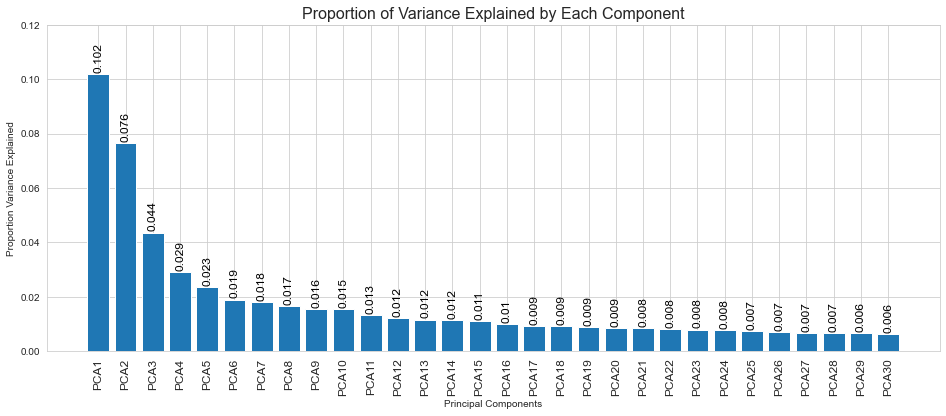

In [219]:
sns.set_style("whitegrid")
gig, ax = plt.subplots(1, 1, figsize=(16, 6))
p = ax.bar(pca_columns, pca.explained_variance_ratio_)
ax.bar_label(p,
             label_type='edge', labels=[round(var_exp, 3) for var_exp in pca.explained_variance_ratio_],
             c="black",
             fontsize=12,
             padding=1.5,
             rotation=90)
ax.set_ylabel("Proportion Variance Explained")
ax.set_xlabel("Principal Components")
ax.set_title("Proportion of Variance Explained by Each Component", fontsize=16)
ax.set_xticklabels(pca_columns, rotation=90, fontsize=12)
ax.set_ylim(0, .12);

### How many components will you use to fit a supervised learning model?

By using `PCA()`'s built in maximum likelihood estimator for choosing the number of components, I found that the optimal choice was 233 components, which described all of the variance in the original data and drops 8 columns. However, in using PCA, I'm hoping to shrink the data much more, so I opt to instead use **30 components**, which only described 54% of the variance in the data, but is much smaller than the original number of columns and so should have considerable computation advantages.

### 2D Scatterplot of the first two components

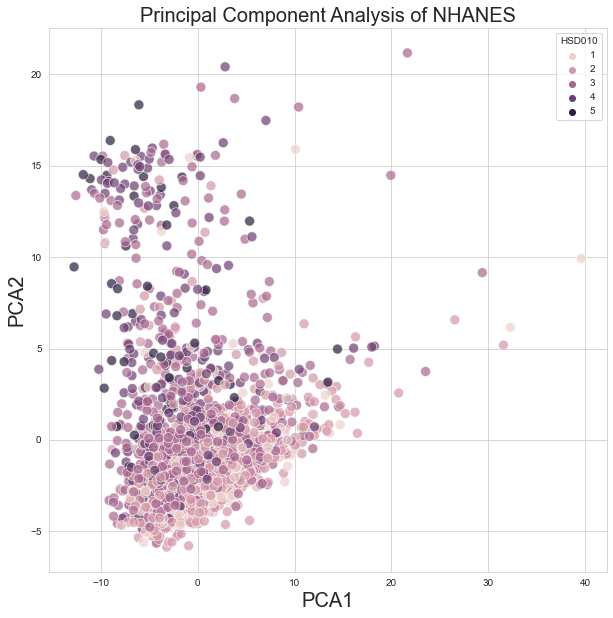

In [220]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel('PCA1',fontsize=20)
ax.set_ylabel('PCA2',fontsize=20)
ax.set_title("Principal Component Analysis of NHANES",fontsize=20)
plotting_df  = pd.concat([pca_df, hsd010], axis=1)
sns.scatterplot(x=plotting_df['PCA1'],
                y=plotting_df['PCA2'],
                hue=plotting_df['HSD010'],
                ax=ax,
                s=100,
                alpha=.7);

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

## Your Answer Here
I will use k-means becasue it ... It works by ...

### Cluster nhanes

Through an iterative process, I have chosen 3 groups for clustering. In the elbow plot below, the first kink in the figure is at k=3.

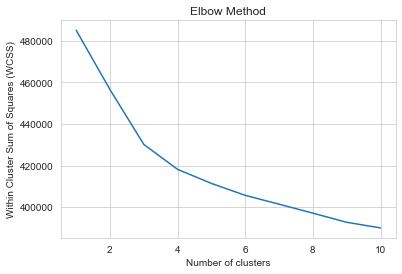

In [139]:
# Determine optimal cluster number with elbow method

wcss = []

for i in range(1, 11):
    model = KMeans(n_clusters = i,     
                    init = 'k-means++',                 # Initialization method for kmeans
                    max_iter = 300,                     # Maximum number of iterations 
                    n_init = 10)                        # Choose how often algorithm will run with different centroid 
    model.fit(nhanes_scaled)                              
    wcss.append(model.inertia_)
    
# Show Elbow plot
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')                               # Set plot title
plt.xlabel('Number of clusters')                        # Set x axis name
plt.ylabel('Within Cluster Sum of Squares (WCSS)')      # Set y axis name
plt.show()

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

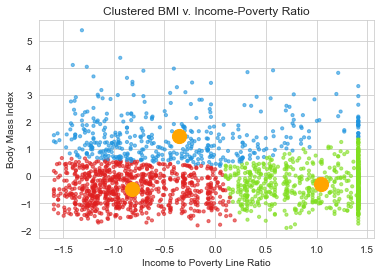

In [140]:
nhanes_scaled_pred = nhanes_scaled 

kmeans = KMeans(n_clusters = 3,                 # Set amount of clusters
                init = 'k-means++',             # Initialization method for kmeans
                max_iter = 300,                 # Maximum number of iterations
                n_init = 10,                    # Choose how often algorithm will run with different centroid
                random_state = 0)               # Choose random state for reproducibility

nhanes_scaled_pred['cluster'] = kmeans.fit_predict(nhanes_scaled[['INDFMPIR', 'BMXBMI']])

# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
nhanes_scaled_pred['cen_x'] = nhanes_scaled_pred.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
nhanes_scaled_pred['cen_y'] = nhanes_scaled_pred.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
nhanes_scaled_pred['c'] = nhanes_scaled_pred.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

plt.title("Clustered BMI v. Income-Poverty Ratio")
plt.xlabel("Income to Poverty Line Ratio")
plt.ylabel("Body Mass Index")
plt.scatter(nhanes_scaled_pred.INDFMPIR, nhanes_scaled_pred.BMXBMI, c=nhanes_scaled_pred.c, alpha = 0.6, s=10)
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:, 1], 
            s=200,                             # Set centroid size
            c='orange')                           # Set centroid color

Using three clusters in k-means clustering created through groups. The orange points show the centroids of each groups, separated by color. These groups do not look to my eye to be intuitive separations of the data. 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

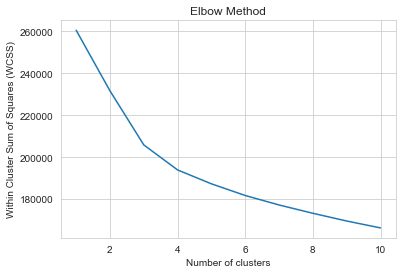

In [141]:
## Again, choose 3 clusters.

# Determine optimal cluster number with elbow method

wcss = []

for i in range(1, 11):
    model = KMeans(n_clusters = i,     
                    init = 'k-means++',                 # Initialization method for kmeans
                    max_iter = 300,                     # Maximum number of iterations 
                    n_init = 10)                        # Choose how often algorithm will run with different centroid 
    model.fit(pca_df)                              
    wcss.append(model.inertia_)
    
# Show Elbow plot
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')                               # Set plot title
plt.xlabel('Number of clusters')                        # Set x axis name
plt.ylabel('Within Cluster Sum of Squares (WCSS)')      # Set y axis name
plt.show()

In [142]:
pca_df_pred

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30,cluster,cen_x,cen_y,c
0,9.527811,-0.816178,-1.866740,-2.110925,-3.924628,-0.193646,-3.849652,-2.934949,1.523273,0.688784,...,-0.593424,0.219617,-0.394934,0.776137,0.898143,-0.349745,1,5.948360,0.309295,#81DF20
1,-5.838361,-3.692573,3.804999,-1.031667,0.383835,1.627550,2.686653,-0.802590,0.408529,-2.351917,...,0.551637,2.059600,-2.608773,-1.592425,-0.290499,-0.562368,0,-1.930728,-1.649926,#DF2020
2,-0.719451,-2.573145,0.907735,-4.755542,-1.794284,0.887014,-1.027608,0.654357,0.531868,0.460322,...,-0.310767,-0.319732,0.694585,0.815367,0.232887,-1.983309,0,-1.930728,-1.649926,#DF2020
3,3.533614,-2.577043,-3.249342,-0.403753,3.995951,1.444801,-1.189930,0.322879,-4.141131,-1.238751,...,-1.029006,1.559880,-0.011785,1.062441,0.682329,0.070311,1,5.948360,0.309295,#81DF20
4,-6.872095,-4.194171,0.887105,-0.853758,-0.523529,0.076011,0.848739,0.981640,0.547544,-0.052914,...,-0.390675,0.235913,1.662597,-1.695507,1.145720,-1.673504,0,-1.930728,-1.649926,#DF2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,2.643321,-1.689356,-0.702250,-0.539260,-1.016836,-0.684139,0.485125,-0.265181,0.947613,-1.250795,...,-0.333205,1.356617,-0.660921,-1.382637,-0.516196,0.379856,1,5.948360,0.309295,#81DF20
2060,1.037894,-0.118092,5.556360,1.630483,0.970103,1.157935,1.944837,0.930471,-1.282682,-2.027466,...,-0.411264,-0.533419,0.916586,0.391050,-1.369066,-0.103006,0,-1.930728,-1.649926,#DF2020
2061,1.130254,-0.970432,3.415471,1.203694,-3.634234,1.115642,1.361527,1.813266,-2.347588,0.223428,...,1.732541,0.542831,2.181002,0.567177,-0.613237,0.453543,0,-1.930728,-1.649926,#DF2020
2062,7.145094,-0.376732,1.753543,-0.939401,-4.664605,3.840853,-1.355358,2.592749,-0.300954,0.620983,...,-0.364846,-0.868200,0.636497,1.712075,0.851456,-0.480757,1,5.948360,0.309295,#81DF20


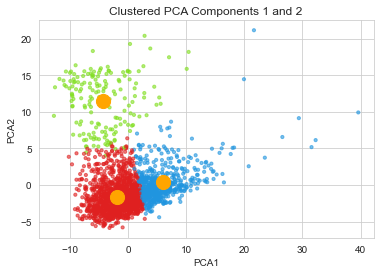

In [163]:
pca_df_pred = pca_df 

kmeans = KMeans(n_clusters = 3,                 # Set amount of clusters
                init = 'k-means++',             # Initialization method for kmeans
                max_iter = 300,                 # Maximum number of iterations
                n_init = 10,                    # Choose how often algorithm will run with different centroid
                random_state = 0)               # Choose random state for reproducibility

pca_df_pred['cluster'] = kmeans.fit_predict(pca_df)

# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
pca_df_pred['cen_x'] = pca_df_pred.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
pca_df_pred['cen_y'] = pca_df_pred.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
pca_df_pred['c'] = pca_df_pred.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

plt.title("Clustered PCA Components 1 and 2")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.scatter(pca_df_pred.PCA1, pca_df_pred.PCA2, c=pca_df_pred.c, alpha = 0.6, s=10)
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:, 1], 
            s=200,                             # Set centroid size
            c='orange')                           # Set centroid color

## Using the features selected from PCA, the clusters seem to be doing a better job. However, a different clustering method may produce better results, as the vertical split between the red and green clusters does not seem clear.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [157]:
y = hsd010.values.flatten() # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [158]:
import keras
from keras.utils import np_utils 

num_classes = len(np.unique(y)) + 1
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [159]:
model = Sequential()

model.add(
    Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')
)

model.add(
    Dense(num_classes, kernel_initializer="normal", activation="softmax")
)

## Add any additional layers you wish here

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=500, verbose=2)

Epoch 1/30
4/4 - 1s - loss: 1.7671 - accuracy: 0.2590 - auc: 0.5914 - val_loss: 1.5684 - val_accuracy: 0.3682 - val_auc: 0.7506 - 1s/epoch - 275ms/step
Epoch 2/30
4/4 - 0s - loss: 1.4351 - accuracy: 0.4522 - auc: 0.8085 - val_loss: 1.4168 - val_accuracy: 0.4147 - val_auc: 0.8001 - 32ms/epoch - 8ms/step
Epoch 3/30
4/4 - 0s - loss: 1.2837 - accuracy: 0.4935 - auc: 0.8411 - val_loss: 1.3463 - val_accuracy: 0.4360 - val_auc: 0.8162 - 32ms/epoch - 8ms/step
Epoch 4/30
4/4 - 0s - loss: 1.2024 - accuracy: 0.5155 - auc: 0.8567 - val_loss: 1.3091 - val_accuracy: 0.4477 - val_auc: 0.8245 - 31ms/epoch - 8ms/step
Epoch 5/30
4/4 - 0s - loss: 1.1414 - accuracy: 0.5297 - auc: 0.8698 - val_loss: 1.2816 - val_accuracy: 0.4554 - val_auc: 0.8299 - 31ms/epoch - 8ms/step
Epoch 6/30
4/4 - 0s - loss: 1.0858 - accuracy: 0.5484 - auc: 0.8827 - val_loss: 1.2568 - val_accuracy: 0.4554 - val_auc: 0.8351 - 31ms/epoch - 8ms/step
Epoch 7/30
4/4 - 0s - loss: 1.0357 - accuracy: 0.5756 - auc: 0.8950 - val_loss: 1.2415 -

### Neural Network on Principal Components

In [162]:
X_train, X_test, y_train, y_test = train_test_split(pca_df.values, y, test_size = .25, random_state = 10)

num_classes = len(np.unique(y)) + 1
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

model = Sequential()

model.add(
    Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')
)
model.add(
    Dense(num_classes, kernel_initializer="normal", activation="softmax")
)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=100, verbose=2)

Epoch 1/30
16/16 - 1s - loss: 1.7623 - accuracy: 0.2687 - auc: 0.6114 - val_loss: 1.7098 - val_accuracy: 0.3547 - val_auc: 0.7358 - 618ms/epoch - 39ms/step
Epoch 2/30
16/16 - 0s - loss: 1.6624 - accuracy: 0.3766 - auc: 0.7812 - val_loss: 1.6151 - val_accuracy: 0.3798 - val_auc: 0.8023 - 54ms/epoch - 3ms/step
Epoch 3/30
16/16 - 0s - loss: 1.5652 - accuracy: 0.4264 - auc: 0.8133 - val_loss: 1.5213 - val_accuracy: 0.4283 - val_auc: 0.8146 - 50ms/epoch - 3ms/step
Epoch 4/30
16/16 - 0s - loss: 1.4689 - accuracy: 0.4703 - auc: 0.8253 - val_loss: 1.4333 - val_accuracy: 0.4574 - val_auc: 0.8234 - 55ms/epoch - 3ms/step
Epoch 5/30
16/16 - 0s - loss: 1.3801 - accuracy: 0.4877 - auc: 0.8354 - val_loss: 1.3588 - val_accuracy: 0.4864 - val_auc: 0.8322 - 64ms/epoch - 4ms/step
Epoch 6/30
16/16 - 0s - loss: 1.3072 - accuracy: 0.5032 - auc: 0.8440 - val_loss: 1.3023 - val_accuracy: 0.4922 - val_auc: 0.8380 - 59ms/epoch - 4ms/step
Epoch 7/30
16/16 - 0s - loss: 1.2521 - accuracy: 0.5129 - auc: 0.8508 - va

### Neural Network on Principal Components + Cluster Membership

In [221]:
## Your Answer Here
y = hsd010.values.flatten() # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 

nhanes_scaled_pred2 = nhanes_scaled_pred['cluster'].reset_index(drop=True)
merged_cluster_pca = pd.concat([pca_df, nhanes_scaled_pred2], axis=1)

X_train, X_test, y_train, y_test = train_test_split(merged_cluster_pca.values, y, test_size = .25, random_state = 10)

num_classes = len(np.unique(y)) + 1
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

model = Sequential()

model.add(
    Dense(X_train.shape[1], input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')
)
model.add(
    Dense(num_classes, kernel_initializer="normal", activation="softmax")
)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=100, verbose=2)

Epoch 1/30
16/16 - 1s - loss: 1.7563 - accuracy: 0.2694 - auc: 0.6424 - val_loss: 1.7035 - val_accuracy: 0.4128 - val_auc: 0.7648 - 1s/epoch - 78ms/step
Epoch 2/30
16/16 - 0s - loss: 1.6525 - accuracy: 0.4302 - auc: 0.7934 - val_loss: 1.6059 - val_accuracy: 0.4574 - val_auc: 0.8031 - 56ms/epoch - 4ms/step
Epoch 3/30
16/16 - 0s - loss: 1.5518 - accuracy: 0.4587 - auc: 0.8141 - val_loss: 1.5088 - val_accuracy: 0.4496 - val_auc: 0.8141 - 57ms/epoch - 4ms/step
Epoch 4/30
16/16 - 0s - loss: 1.4530 - accuracy: 0.4742 - auc: 0.8217 - val_loss: 1.4203 - val_accuracy: 0.4496 - val_auc: 0.8212 - 48ms/epoch - 3ms/step
Epoch 5/30
16/16 - 0s - loss: 1.3681 - accuracy: 0.4910 - auc: 0.8300 - val_loss: 1.3489 - val_accuracy: 0.4612 - val_auc: 0.8283 - 48ms/epoch - 3ms/step
Epoch 6/30
16/16 - 0s - loss: 1.3010 - accuracy: 0.5000 - auc: 0.8394 - val_loss: 1.2961 - val_accuracy: 0.4690 - val_auc: 0.8356 - 55ms/epoch - 3ms/step
Epoch 7/30
16/16 - 0s - loss: 1.2515 - accuracy: 0.5006 - auc: 0.8473 - val_l

Final epoch for solely PCA:
16/16 - 0s - loss: 0.9688 - accuracy: 0.5801 - auc: 0.9009 - val_loss: 1.0984 - val_accuracy: 0.5116 - val_auc: 0.8698 - 39ms/epoch - 2ms/step

Final epoch for PCA + Cluster:
16/16 - 0s - loss: 0.9707 - accuracy: 0.5879 - auc: 0.9025 - val_loss: 1.1050 - val_accuracy: 0.4884 - val_auc: 0.8664 - 40ms/epoch - 3ms/step

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

**Answer**

PCA reduces a dataset into fewer features that capture groups of data into separate variables. Clustering does not change the data but calculates relative distance between groups of data. Fundamentally, PCA transforms datasets and clustering describes group patterns within datasets.

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

**Answer**

Using the features to prioritize through PCA provided for a more interpretable visualization of the clustered groups. In the neural net prediction, combining PCA and K-means resulted in slightly higher loss, accuracy, and AUC.


## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"  
**Answer** 
- Unsupervised learning techniques like PCA can be extremely useful for strategically shrinking "big data" so as to make running complex models -- Neural Nets, CNNs -- much less computationally demanding. For example, using a dataframe with just 30 principle components, we got basically the same out-of-sample Area Under The Curve (AUC) as when we used the entirety of the data (almost 250 columns).